In [46]:
#=
using Pkg
Pkg.add("CSV")
Pkg.add("OrdinaryDiffEq")
Pkg.add("StatsPlots")
Pkg.add("Turing")
Pkg.add("BenchmarkTools")
=#

In [5]:
using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, OrdinaryDiffEq, StatsPlots, Turing, DataFrames
using BenchmarkTools
using Random; Random.seed!(2)

include("Functions.jl")
#Model\Functions.jl
# ss = [0.19221352181589382, 0.025370121153103352, 0.003470710756175975]
# ss = [0.1980838489553699, 0.3398764604660583, 0.021953988325962473]
ss =[0.1965540993719682, 0.33710688311783643, 0.021763394501028103]

3-element Vector{Float64}:
 0.1965540993719682
 0.33710688311783643
 0.021763394501028103

In [7]:
@parameters Vm_GPI Vm_PFK2 Vm_FBP Vm_ALD Kc_PFKM # V values. Vm are Vmax forward for each enzyme.
@parameters C_G6P C_DHAP C_ATP C_ADP C_AMP C_cit C_GAP C_Pi C_AMPK C_PFKM

#C_ATP = exp(-5.643)*1000 #M to mM
#C_ADP = exp(-6.616)*1000
#C_cit = exp(-3.930)*1000
#C_AMP = exp(-12.151)*1000
#C_PFKM = 4*10^-5
#C_AMPK = 5.7875*10^-1 #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
#C_Pi = 1
#C_G6P = exp(-7.762)*1000
#C_GAP = exp(-15.059)*1000 
#C_DHAP = exp(-13.059)*1000 

L_PFKM = 2*10^9
L_PFK2 = 1*10^-3
#=
V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2]
=#
Keq_GPI =  0.492
Keq_PFKM = 1.96675 *10^3
Keq_PFK2 = 16.0
Keq_FBP = 56.4458
Keq_ALD = 0.0173

Kf_GPI = 0.3
Kr_GPI = 0.123 #0.123
Ki_ATP = 0.1
Ki_cit = 0.1 #
Ka_f6p = 6*10^-2
Ka_f16bp = 0.35 #0.35 for PFKM and 0.65 for PFKL
Ka_AMP = 0.3
Ka_f26bp = 5.5*10^-8 # 5.5*10^-3
# Kc_PFKM = 15.5*10^2/(4*10^-5) # Changed from 15.5*10^2/4*10^-5
K_f6p = 6*10^-2
K_ATP = 6.8*10^-2
K_f16bp = 0.65
K_ADP = 0.54
Kc_AMPK = 0.1 # Check this
v_P = 0.005 # Check this
K2_ATP = 0.15
K2_f6p = 0.032
K2_f26bp = 0.008
K2_ADP = 0.062
K_FBP_f26bp = 1*10^-3
K_FBP_f6p = 25*10^-3
K_Pi = 0.23 #
KAld_f16bp = 5*10^-2
K_GAP = 0.189
K_DHAP = 3.5*10^-2 

@variables t f6p(t) f16bp(t) f26bp(t)
D = Differential(t)

r_GPI = (Vm_GPI/Kf_GPI)*(C_G6P-(f6p/Keq_GPI))/
    (1 + C_G6P/Kf_GPI + f6p/Kr_GPI)
    
N_PFKM = 1 + L_PFKM*(1 + C_ATP/Ki_ATP)^4*(1 + C_cit/Ki_cit)^4/
    ((1 + f6p/Ka_f6p + f16bp/Ka_f16bp)^4 * (1 + C_AMP/Ka_AMP)^4 * (1 + f26bp/Ka_f26bp)^4)

r_PFKM = ((C_PFKM*(Kc_PFKM/(K_f6p*K_ATP))*(C_ATP*f6p - C_ADP*f16bp/Keq_PFKM))/
    ((1 + f6p/K_f6p)*(1 + C_ATP/K_ATP) + (1 + f16bp/K_f16bp)*(1 + C_ADP/K_ADP) -1))*
    (1/N_PFKM)

psi = (Kc_AMPK*C_AMPK)/((Kc_AMPK*C_AMPK)+v_P)
N_PFK2 = 1 + L_PFK2*(psi/(1-psi))^2

r_PFK2 = (Vm_PFK2/(K2_ATP*K2_f6p))*((C_ATP*f6p)-(C_ADP*f26bp)/Keq_PFK2)/
    ((1+f6p/K2_f6p)*(1+C_ATP/K2_ATP) + (1+f26bp/K2_f26bp)*(1+C_ADP/K2_ADP) -1) *
    (1-(1/N_PFK2))

r_FBP = (Vm_FBP/(K_FBP_f26bp))*(f26bp-(f6p*C_Pi)/Keq_FBP)/
    ((1+f26bp/K_FBP_f26bp) + (1+f6p/K_FBP_f6p)*(1+C_Pi/K_Pi)-1) * 
    (1/N_PFK2)

r_ALD = (Vm_ALD/KAld_f16bp)*(f16bp-(C_GAP*C_DHAP)/Keq_ALD)/
    ((1 + f6p/KAld_f16bp) + (1 + C_GAP/K_GAP)*(1 + C_DHAP/K_DHAP) -1)

eqs = [D(f6p) ~ r_GPI - r_PFKM - r_PFK2 + r_FBP,
    D(f16bp) ~ r_PFKM - r_ALD,
    D(f26bp) ~ r_PFK2 - r_FBP]

@named sys = ODESystem(eqs, t)

sys=structural_simplify(sys)

Model sys with 3 equations
Unknowns (3):
  f6p(t)
  f16bp(t)
  f26bp(t)
Parameters (15):
  C_Pi
  Vm_GPI
  Vm_FBP
  Vm_PFK2
⋮
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

In [8]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]

V = [Vm_GPI => 4.8*10^4,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Vm_ALD => 6.75*10^2,
    Kc_PFKM => 3.875*10^7]

Cons = [C_ATP => exp(1.257), 
    C_ADP => exp(0.284), 
    C_cit => exp(2.97),
    C_AMP => exp(-5.251),
    C_PFKM => 4*10^-5,
    C_AMPK => 5.7875*10^-1, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1,
    C_G6P => exp(-0.862),
    C_GAP => exp(-8.159), # No data
    C_DHAP => exp(-6.159)]

p= [V
    Cons]    
tspan = (0.0, 10)
prob = ODEProblem(sys, u0, tspan, p, jac = true)

sol = solve(prob, Rodas4(), save_everystep = false);

print(sol[end])

[0.1965540993719682, 0.3371068831178366, 0.021763394501028106]

In [8]:
#=
Vm_GPI = 4.8*10^4
Vm_PFK2 = 41.6
Vm_FBP = 11.78 
Vm_ALD = 6.75*10^2
p=[Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD]
=#

4-element Vector{Float64}:
 48000.0
    41.6
    11.78
   675.0

In [9]:
#=
sol = solve(prob, Rodas4(); p = p, saveat = 0.1)
ss1 = sol[end]
=#

3-element Vector{Float64}:
 0.19221352181589382
 0.025370121153103352
 0.003470710756175975

In [20]:
print(ss)

[0.19221352181589382, 0.025370121153103352, 0.003470710756175975]

In [ ]:
#=
C_ATP ~ LogNormal(-5.643+6.9, 0.166) #M to mM
C_ADP ~ LogNormal(-6.616+6.9, 0.169) 
C_cit ~ LogNormal(-3.930+6.9, 0.225)
C_AMP ~ LogNormal(-12.151+6.9, 0.274)
C_G6P ~ LogNormal(-7.762+6.9, 0.314) 
C_GAP ~ LogNormal(-15.059+6.9, 0.165) # No data
C_DHAP ~ LogNormal(-13.059+6.9, 0.165)
=#

In [9]:
u0 = [f6p => 1*10^-3,
    f16bp => 1*10^-3,
    f26bp => 1*10^-3]


V = [Vm_GPI => 4*10^4,
    Vm_PFK2 => 40,
    Vm_FBP => 12, 
    Vm_ALD => 6*10^2,
    Kc_PFKM => 13.875*10^7]

Cons = [C_ATP => exp(1),
    C_ADP => exp(1), 
    C_cit => exp(1),
    C_AMP => exp(-5),
    C_PFKM => 0.00001,
    C_AMPK => 0.1, #WT: 5.7875*10^-5 and Zela: 6.8275*10^-5
    C_Pi => 1,
    C_G6P => exp(1), 
    C_GAP => exp(-5),
    C_DHAP => exp(-5)]

p= [V
    Cons]

tspan = (0.0, 10)
prob = ODEProblem(sys, u0, tspan, p, jac = true)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 3-element Vector{Float64}:
 0.001
 0.001
 0.001

In [10]:
@model function mymodelRodas4(data, prob)
    Vm_GPI ~ LogNormal(log(4.8*10^4), 1) 
    Vm_PFK2 ~ LogNormal(log(41.6), 1) 
    Vm_FBP ~ LogNormal(log(11.78), 1)
    Vm_ALD ~ LogNormal(log(6.75*10^2), 1) 
    Kc_PFKM ~ LogNormal(log(3.875*10^7), 1)

    C_ATP ~ LogNormal(1.257, 0.166) #M to mM
    C_ADP ~ LogNormal(0.284, 0.169) 
    C_cit ~ LogNormal(2.97, 0.225)
    C_AMP ~ LogNormal(-5.251, 0.274)
    C_PFKM ~ LogNormal(log(4*10^(-5)), 0.5)
    C_AMPK ~ LogNormal(log(4*10^(-5)), 0.5)
    C_Pi ~ LogNormal(log(1), 1)
    C_G6P ~ LogNormal(-0.862, 0.314) 
    C_GAP ~ LogNormal(-8.159, 0.165) # No data
    C_DHAP ~ LogNormal(-6.159, 0.165)

    sigma ~ LogNormal(-1.2, 0.7)
    p=[Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD, Kc_PFKM, C_ATP, C_ADP, C_cit, C_AMP, C_Pi, C_AMPK, C_PFKM, C_G6P, C_GAP, C_DHAP]
    sol = solve(prob, Rodas4(), save_everystep = false)
    ss1 = sol[end]
    for i in 1:3
        data[i] ~ LogNormal(log(ss1[i]), sigma)
    end
end


mymodelRodas4 (generic function with 2 methods)

In [11]:
model = mymodelRodas4(ss, prob)

DynamicPPL.Model{typeof(mymodelRodas4), (:data, :prob), (), (), Tuple{Vector{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, ModelingToolkit.MTKParameters{Tuple{Vector{Float64}}, Tuple{}, Tuple{}, Tuple{}, Tuple{}, Nothing, Nothing}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#683"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x5886db4e, 0xe4711eb6, 0x4ed7d305, 0x353fe41d, 0xc6e99c3c), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x1778c290, 0x09be5256, 0x9e10627c, 0x4b0cc3f7, 0xe67c594a), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, ModelingToolkit.var"#_jac#688"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", 

In [12]:
sampler = NUTS()

samples = 1000

chain = sample(model, sampler, samples)


Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\alber\.julia\packages\Turing\lkUBK\src\mcmc\hmc.jl:191
Sampling   0%|█                                         |  ETA: 2:28:18
Sampling   1%|█                                         |  ETA: 1:14:09
Sampling   1%|█                                         |  ETA: 0:49:24
Sampling   2%|█                                         |  ETA: 0:37:01
Sampling   2%|█                                         |  ETA: 0:29:34
Sampling   3%|██                                        |  ETA: 0:24:35
Sampling   3%|██                                        |  ETA: 0:21:02
Sampling   4%|██                                        |  ETA: 0:18:25
Sampling   4%|██                                        |  ETA: 0:16:22
Sampling   5%|██                                        |  ETA: 0:14:42
Sampling   5%|███                                       |  ETA: 0:13:21
Sampling   

Chains MCMC chain (1000×28×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 69.45 seconds
Compute duration  = 69.45 seconds
parameters        = Vm_GPI, Vm_PFK2, Vm_FBP, Vm_ALD, Kc_PFKM, C_ATP, C_ADP, C_cit, C_AMP, C_PFKM, C_AMPK, C_Pi, C_G6P, C_GAP, C_DHAP, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters            mean             std           mcse    ess_bulk   ess_ ⋯
      Symbol         Float64         Float64        Float64     Float64    Flo ⋯

      Vm_GPI      83495.7816     105539.9419      4086.6716   1470.3575   643. ⋯
     Vm_PFK2         69.4250         88.6430         2.9604   1644.5974   720. ⋯
      Vm_FBP         19.2985         23.6812         0.7678   1206.3230   572. ⋯
      Vm_ALD       1190.8743      

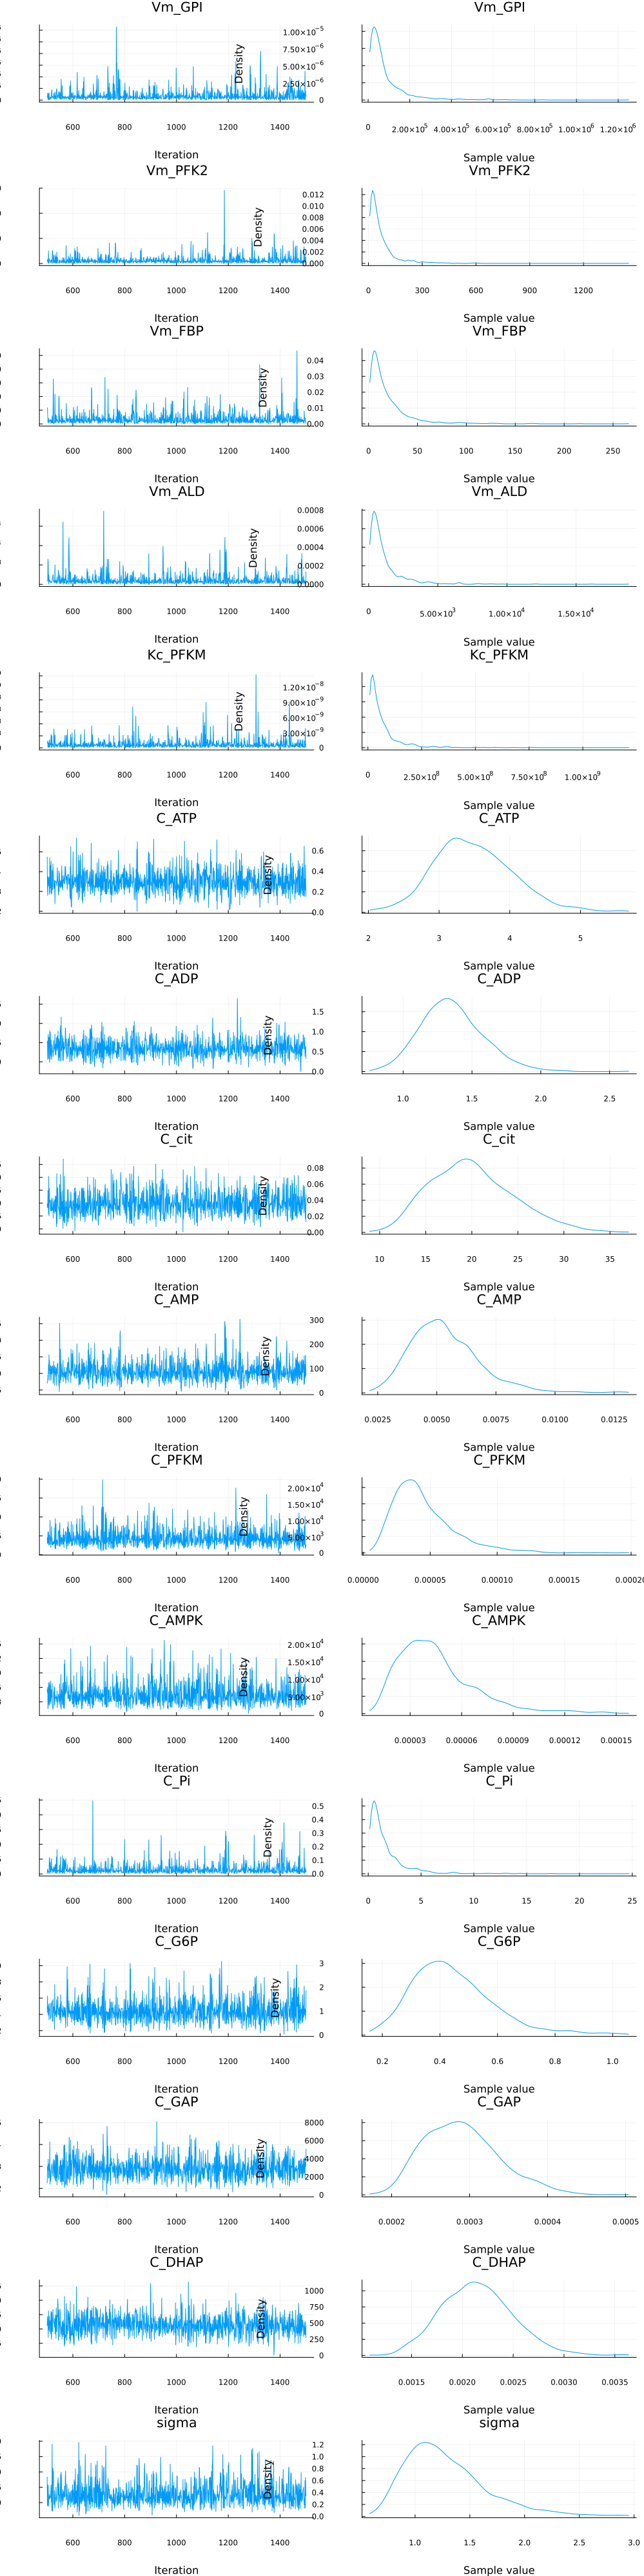

In [13]:
# visualize results
plot(chain)